Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

C:\Users\tigju\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
target = 'status_group'
train, val = train_test_split(train, test_size=len(test), stratify=train[target], random_state=42)

In [5]:
train.shape, val.shape

((45042, 41), (14358, 41))

In [6]:
def clean_up(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    
    #reduce cardinality
    top20_col = ['lga', 'installer', 'funder']
    for col in top20_col:
        top20 = X[col].value_counts()[:20].index
        X.loc[~X[col].isin(top20), col] = 'other'
        
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id', 'num_private', 'scheme_name']  
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
#     # Create interaction between amount of water avaialable and population
    X['pop*amount_tsh'] = X['population'] * X['amount_tsh']
    X['pop/amount_tsh'] = X['population'] / X['amount_tsh']
    X['pop/amount_tsh'] = X['pop/amount_tsh'].replace(np.inf, 3000)
    
#     X['pop**2'] = X['population'] ** 2
    
    # return the wrangled dataframe
    return X

In [7]:
train = clean_up(train)
val = clean_up(val)
test = clean_up(test)

In [8]:
# define target
target = 'status_group'

# define features
features = train.drop(columns=[target])

numeric_features = features.select_dtypes(include='number').columns.tolist()

cardinality = features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 60].index.tolist()

features = numeric_features + categorical_features
features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'years',
 'pop*amount_tsh',
 'pop/amount_tsh',
 'funder',
 'installer',
 'basin',
 'region',
 'lga',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'longitude_MISSING',
 'latitude_MISSING',
 'construction_year_MISSING',
 'gps_height_MISSING',
 'population_MISSING',
 'years_MISSING']

In [9]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test

In [10]:
%%time
pipeline = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=584, random_state=42, n_jobs=-1, max_depth=25, max_features=0.2557414512751396, min_samples_split=4)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8167572085248642
Wall time: 1min 12s


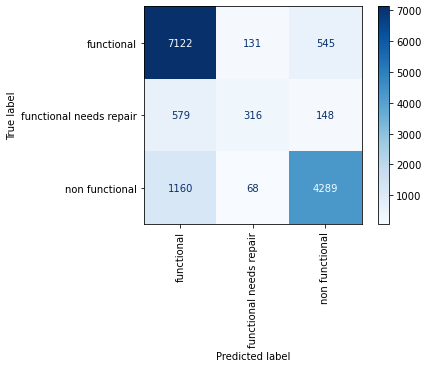

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='vertical', 
                      values_format='.0f', 
                      cmap='Blues');

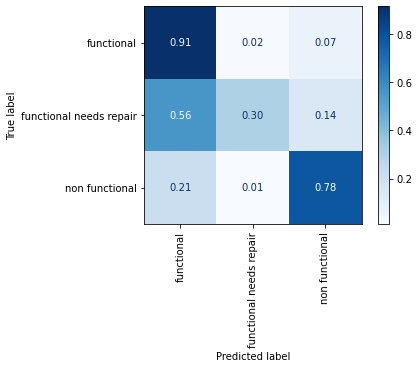

In [12]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='vertical', 
                      values_format='.2f',
                      normalize='true', 
                      cmap='Blues');

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
cm

array([[7122,  131,  545],
       [ 579,  316,  148],
       [1160,   68, 4289]], dtype=int64)

In [14]:
normalized_cm = cm/cm.sum(axis=1)[:, np.newaxis]
normalized_cm

array([[0.91331111, 0.01679918, 0.06988972],
       [0.55512943, 0.3029722 , 0.14189837],
       [0.2102592 , 0.01232554, 0.77741526]])

In [15]:
cm.sum(axis=1)[:, np.newaxis]

array([[7798],
       [1043],
       [5517]], dtype=int64)

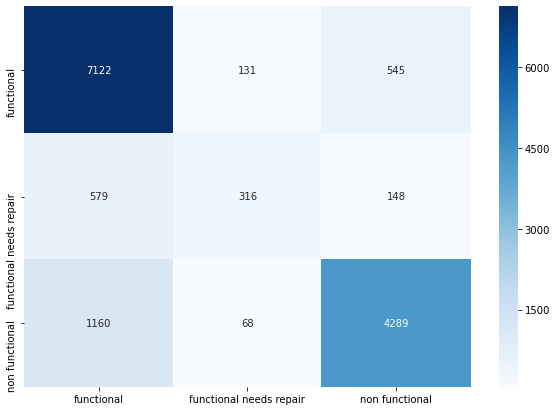

In [16]:
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

cols = unique_labels(y_val)
df_cm = pd.DataFrame(cm,columns=cols, index=cols)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.0f')
plt.show()

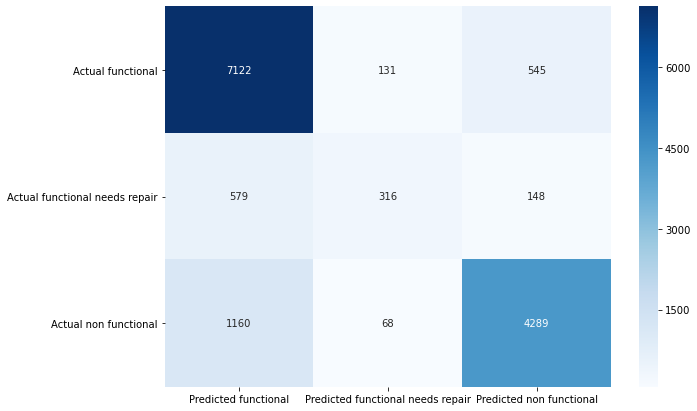

In [17]:
def plot_cm(y_val, y_pred, normalize=False):
  cols = unique_labels(y_val)
  cm = confusion_matrix(y_val, y_pred)
  if normalize:
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    fmt='.2f'
  else:
    fmt='.0f'
  df_cm = pd.DataFrame(cm,
                       columns=['Predicted '+str(col) for col in cols], 
                       index=['Actual '+str(col) for col in cols])
  plt.figure(figsize=(10,7))
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt)

plot_cm(y_val, y_pred)

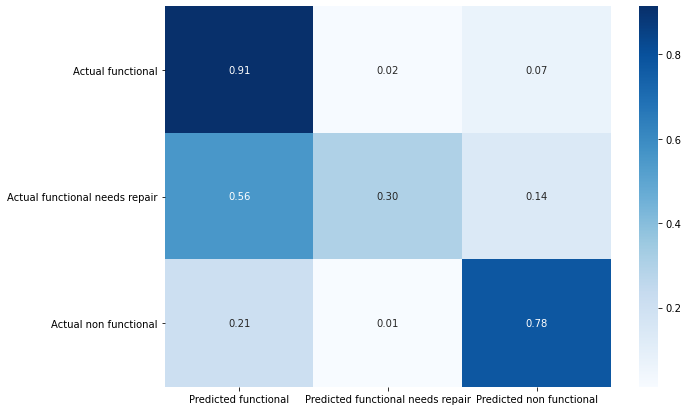

In [18]:
plot_cm(y_val, y_pred, normalize=True)

In [19]:
# correct predictions
7122 + 316 + 4289

11727

In [20]:
# total predictions
len(y_val)

14358

In [21]:
# classification accuracy 
11727/14358

0.8167572085248642

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_val,y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.86      7798
functional needs repair       0.61      0.30      0.41      1043
         non functional       0.86      0.78      0.82      5517

               accuracy                           0.82     14358
              macro avg       0.76      0.66      0.69     14358
           weighted avg       0.81      0.82      0.81     14358



In [23]:
y_pred_baseline = ['functional']*len(y_pred)

In [24]:
print(classification_report(y_val,y_pred_baseline))

C:\Users\tigju\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      7798
functional needs repair       0.00      0.00      0.00      1043
         non functional       0.00      0.00      0.00      5517

               accuracy                           0.54     14358
              macro avg       0.18      0.33      0.23     14358
           weighted avg       0.29      0.54      0.38     14358



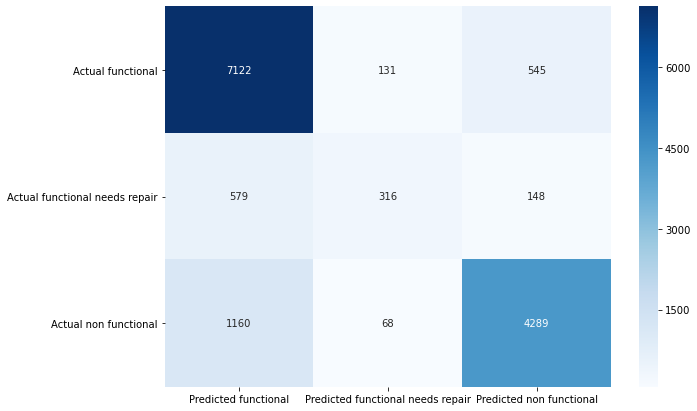

In [25]:
plot_cm(y_val,y_pred)

In [26]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.86      7798
functional needs repair       0.61      0.30      0.41      1043
         non functional       0.86      0.78      0.82      5517

               accuracy                           0.82     14358
              macro avg       0.76      0.66      0.69     14358
           weighted avg       0.81      0.82      0.81     14358



In [27]:
# correct predictions of non-functional
correct_pred_non_func = 4289

In [28]:
# total predictions of non-functional
total_pred_non_func = 545 + 148 + 4289
total_pred_non_func

4982

In [29]:
# precision of non-functional
correct_pred_non_func/total_pred_non_func

0.8608992372541148

In [30]:
# actual non-functional water pumps
actual_non_func = 1160 + 68 + 4289
actual_non_func

5517

In [31]:
# recall
correct_pred_non_func/actual_non_func

0.7774152619177089

In [32]:
# f1 score
2*(0.860*0.777)/(0.860+0.777)

0.8163958460598656

In [33]:
# redefine target
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [34]:
# refit the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

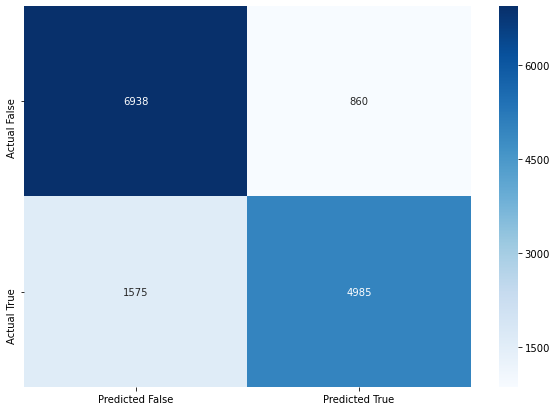

In [35]:
plot_cm(y_val, y_pred)

In [36]:
# how many predictions of true (non-functional or needs repair)
y_pred.sum()

5845

In [37]:
# get predicted probabilities and plot the distribution
pipeline.predict_proba(X_val)

array([[3.19141547e-05, 9.99968086e-01],
       [2.09117820e-01, 7.90882180e-01],
       [9.96069927e-01, 3.93007264e-03],
       ...,
       [7.64180798e-01, 2.35819202e-01],
       [6.57365730e-01, 3.42634270e-01],
       [9.82452246e-01, 1.75477540e-02]])

In [38]:
pipeline.predict(X_val)

array([ True,  True, False, ..., False, False, False])

In [39]:
pipeline.predict_proba(X_val)[:, 1]

array([0.99996809, 0.79088218, 0.00393007, ..., 0.2358192 , 0.34263427,
       0.01754775])

In [40]:
pipeline.predict_proba(X_val)[:, 1] > 0.5

array([ True,  True, False, ..., False, False, False])

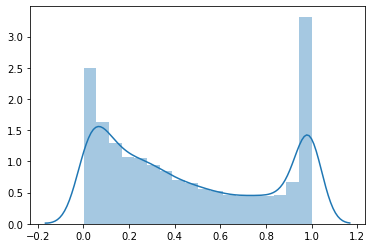

In [41]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba);

False    11448
True      2910
dtype: int64

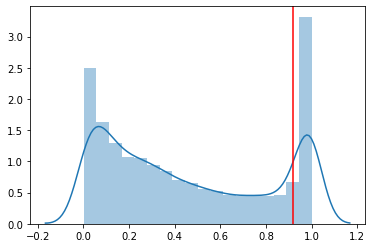

In [42]:
# let's change threshhold
thres = 0.92

y_pred = y_pred_proba > thres

ax = sns.distplot(y_pred_proba)
ax.axvline(thres, color='red')

pd.Series(y_pred).value_counts()

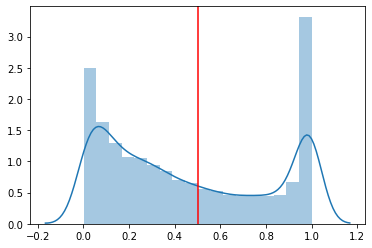

              precision    recall  f1-score   support

       False       1.00      0.74      0.85     11448
        True       0.50      1.00      0.66      2910

    accuracy                           0.80     14358
   macro avg       0.75      0.87      0.76     14358
weighted avg       0.90      0.80      0.81     14358



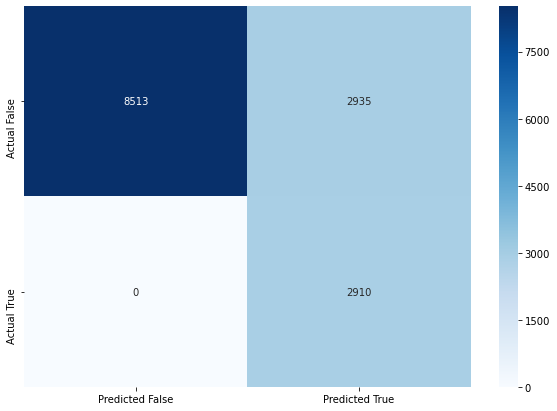

In [43]:
def set_thres(y_val, y_pred_proba, thres=0.5):
  y_pred = y_pred_proba > thres
  ax = sns.distplot(y_pred_proba)
  ax.axvline(thres, color='red')
  plt.show()
  print(classification_report(y_val, y_pred))
  plot_cm(y_val, y_pred)

set_thres(y_pred, y_pred_proba)

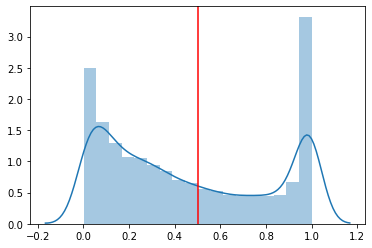

              precision    recall  f1-score   support

       False       0.81      0.89      0.85      7798
        True       0.85      0.76      0.80      6560

    accuracy                           0.83     14358
   macro avg       0.83      0.82      0.83     14358
weighted avg       0.83      0.83      0.83     14358



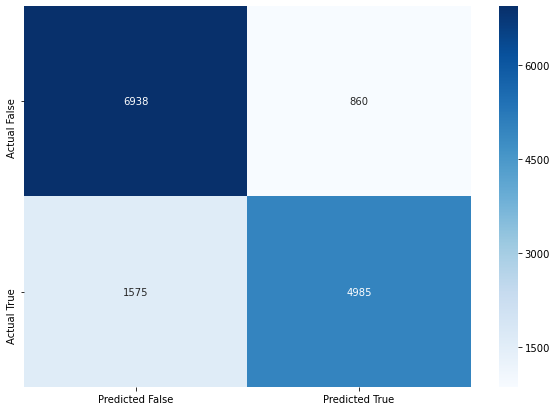

<function __main__.set_thres(y_val, y_pred_proba, thres=0.5)>

In [47]:
from ipywidgets import interact, fixed

interact(set_thres, y_val=fixed(y_val), y_pred_proba=fixed(y_pred_proba), thres=(0,1,0.1))

In [46]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})
results

,y_val,y_pred_proba
58046,True,0.999968
41184,True,0.790882
27587,False,0.003930
53109,False,0.090391
7245,True,0.745120
...,...,...
18760,False,0.893186
36059,True,0.999144
4759,False,0.235819
43621,False,0.342634
